# Autoencoder Training

This notebook trains an Autoencoder on the MNIST dataset to learn a 2D latent
representation of handwritten digits.

## GPU Setup

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
# GPU MEMORY GROWTH
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("WARNING: No GPU detected, running on CPU")

2026-01-04 09:02:43.428433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU(s) available: ['/physical_device:GPU:0']


## Imports

In [2]:
# Standard library imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
import keras
import keras.ops as K
from keras.optimizers import Adam

# Path setup for project utilities
sys.path.insert(0, '../..')    # For project root utils/
sys.path.insert(0, '..')       # For v1/src modules

# Project utilities
from src.utils.loaders import load_mnist
from src.models.AE import Autoencoder
from utils.wandb_utils import init_wandb, get_model_checkpoint
from utils.callbacks import LRFinder, get_lr_scheduler, get_early_stopping, LRLogger
from utils.gpu_utils import (
    find_optimal_batch_size,
    calculate_adjusted_epochs,
    get_gpu_vram_gb,
    print_training_config
)

# W&B
import wandb
from wandb.integration.keras import WandbMetricsLogger

## Global Configuration

In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# STATIC CONFIGURATION
# Model architecture and reference values
# ═══════════════════════════════════════════════════════════════════════════════

# Reference values (original notebook settings for epoch scaling)
REFERENCE_BATCH_SIZE = 32   # Original book value
REFERENCE_EPOCHS = 200      # Original book value

# Initialize BATCH_SIZE (will be optimized later)
BATCH_SIZE = REFERENCE_BATCH_SIZE
EPOCHS = REFERENCE_EPOCHS

# Model configuration
INPUT_DIM = (28, 28, 1)
Z_DIM = 2  # Latent space dimension
ENCODER_FILTERS = [32, 64, 64, 64]
ENCODER_KERNELS = [3, 3, 3, 3]
ENCODER_STRIDES = [1, 2, 2, 1]
DECODER_FILTERS = [64, 64, 32, 1]
DECODER_KERNELS = [3, 3, 3, 3]
DECODER_STRIDES = [1, 2, 2, 1]

# Training configuration
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0
LEARNING_RATE = "auto"  # Will be set by LRFinder

GPU_VRAM_GB = get_gpu_vram_gb()


# W&B configuration
MODEL_TYPE = "autoencoder"
DATASET_NAME = "digits"
OPTIMIZER_NAME = "adam"

# Run folder configuration
SECTION = 'vae'
RUN_ID = '0001'
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATASET_NAME}'

MODE = 'build'  # 'build' for new model, 'load' to continue training

I0000 00:00:1767517370.246675    3217 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## Directory Setup

In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# CREATE RUN DIRECTORIES
# ═══════════════════════════════════════════════════════════════════════════════

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER, exist_ok=True)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))
    print(f"Created run directory: {RUN_FOLDER}")
else:
    print(f"Using existing run directory: {RUN_FOLDER}")

Using existing run directory: ../run/vae/0001_digits


## Load Data

In [5]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = load_mnist()

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")

Training samples: 60000
Test samples: 10000
Image shape: (28, 28, 1)


## Model Architecture

In [6]:
# Build the Autoencoder model
AE = Autoencoder(
    input_dim=INPUT_DIM,
    encoder_conv_filters=ENCODER_FILTERS,
    encoder_conv_kernel_size=ENCODER_KERNELS,
    encoder_conv_strides=ENCODER_STRIDES,
    decoder_conv_t_filters=DECODER_FILTERS,
    decoder_conv_t_kernel_size=DECODER_KERNELS,
    decoder_conv_t_strides=DECODER_STRIDES,
    z_dim=Z_DIM
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.weights.h5'))

## W&B Initialization

In [7]:
# Initialize W&B for experiment tracking
run = init_wandb(
    name="03_01_autoencoder",
    config={
        "model": MODEL_TYPE,
        "dataset": DATASET_NAME,
        "z_dim": Z_DIM,
        "encoder_filters": ENCODER_FILTERS,
        "learning_rate": LEARNING_RATE,  # Will be updated after LRFinder
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": OPTIMIZER_NAME,
        "gpu_vram_gb": GPU_VRAM_GB,
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# OPTIMIZE BATCH SIZE
# Use binary search to find the maximum batch size that fits in GPU memory
# ═══════════════════════════════════════════════════════════════════════════════

if MODE == 'build':  # Only optimize if building new model
    print("\nFinding optimal batch size...")
    BATCH_SIZE = find_optimal_batch_size(AE.model, INPUT_DIM)
    EPOCHS = calculate_adjusted_epochs(REFERENCE_EPOCHS, REFERENCE_BATCH_SIZE, BATCH_SIZE)
    
    # Ensure minimum epochs
    EPOCHS = max(EPOCHS, 150)

    # Update W&B config
    if wandb.run is not None:
        wandb.config.update({
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS
        }, allow_val_change=True)


    # Print final configuration
    print_training_config(
        BATCH_SIZE, EPOCHS,
        reference_batch=REFERENCE_BATCH_SIZE,
        reference_epochs=REFERENCE_EPOCHS,
        vram_gb=GPU_VRAM_GB
    )



Finding optimal batch size...
════════════════════════════════════════════════════════════════
DYNAMIC BATCH SIZE FINDER
════════════════════════════════════════════════════════════════
Model Parameters: 200,963
Estimated Model Memory: 3.1 MB (weights + optimizer + gradients)
Input Shape: (28, 28, 1)
────────────────────────────────────────────────────────────────
Testing batch sizes...


2026-01-04 09:02:59.436821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


  batch_size=    2 ✓
  batch_size=    4 ✓
  batch_size=    8 ✓
  batch_size=   16 ✓
  batch_size=   32 ✓
  batch_size=   64 ✓
  batch_size=  128 ✓
  batch_size=  256 ✓
  batch_size=  512 ✓
  batch_size= 1024 ✓


2026-01-04 09:03:10.143506: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


  batch_size= 2048 ✓


2026-01-04 09:03:12.612945: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-04 09:03:12.961647: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.87GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  batch_size= 4096 ✓
────────────────────────────────────────────────────────────────
✓ No OOM detected. Using: 3680
════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════
TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════
GPU VRAM:       8 GB
Batch Size:     3680 (reference: 32)
Epochs:         150 (reference: 200)
Scale Factor:   0.75x epochs
════════════════════════════════════════════════════════════════


In [9]:
# Encoder summary
AE.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_0 (Conv2D)         │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_1 (Conv2D)         │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_2 (Conv2D)         │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_3 (Conv2D)         │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         6,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,946 (386.51 KB)

 Trainable params: 98,946 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Decoder summary
AE.decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,017 (398.50 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 0 (0.00 B)

## Find Optimal Learning Rate

2026-01-04 09:03:22.288018: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fa354093fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 09:03:22.288122: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-04 09:03:22.412313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-04 09:03:23.752760: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[3680,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3680,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

Optimal Learning Rate (Recommended): 0.000374


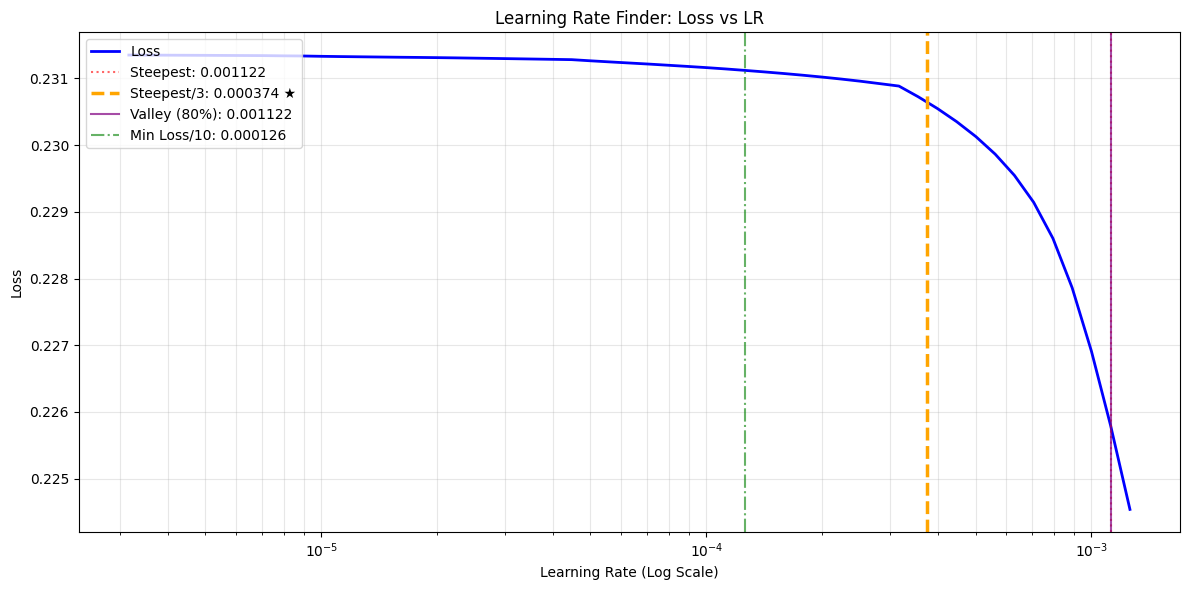

             LR FINDER RESULTS
  🔴 Steepest Gradient : 0.001122  (aggressive)
  🟠 Steepest / 3      : 0.000374  (balanced) ★ DEFAULT
  🟣 Valley (80%)      : 0.001122  (robust)
  🟢 Min Loss / 10     : 0.000126  (conservative)
  Selected Method: 'recommended' → LR = 0.000374

Optimal learning rate: 3.74e-04


In [11]:
# Clone the model to avoid pre-training the actual model
lr_model = tf.keras.models.clone_model(AE.model)

# Define reconstruction loss locally
def r_loss_lr(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

# Compile with small initial LR
lr_model.compile(loss=r_loss_lr, optimizer=Adam(learning_rate=1e-6))

# Run LRFinder
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-1, steps=100)
lr_model.fit(
    x_train, x_train,
    batch_size=BATCH_SIZE,
    epochs=4,
    callbacks=[lr_finder],
    verbose=0
)

# Visualize and get optimal LR
lr_finder.plot_loss()
LEARNING_RATE = lr_finder.get_optimal_lr()

# Update W&B config
wandb.config.update({"learning_rate": LEARNING_RATE})
print(f"\nOptimal learning rate: {LEARNING_RATE:.2e}")

## Train Autoencoder

In [12]:
# Compile with optimal learning rate
AE.compile(LEARNING_RATE)

In [13]:
# Define full callback stack
callbacks = [
    WandbMetricsLogger(),
    get_lr_scheduler(monitor='loss', patience=5),
    get_early_stopping(monitor='loss', patience=20),
    LRLogger(),
]

# Train the model
# lr_decay=1 disables built-in step decay in favor of ReduceLROnPlateau
AE.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    initial_epoch=INITIAL_EPOCH,
    lr_decay=1,
    extra_callbacks=callbacks
)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.2290
Epoch 1: saving model to ../run/vae/0001_digits/weights/weights.weights.h5

Epoch 1: finished saving model to ../run/vae/0001_digits/weights/weights.weights.h5
Epoch 1: Learning Rate is 3.74e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 403ms/step - loss: 0.2260 - learning_rate: 3.7401e-04
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1813
Epoch 2: saving model to ../run/vae/0001_digits/weights/weights.weights.h5

Epoch 2: finished saving model to ../run/vae/0001_digits/weights/weights.weights.h5
Epoch 2: Learning Rate is 3.74e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 0.1504 - learning_rate: 3.7401e-04
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0985
Epoch 3: saving model to ../run/vae/0001_digits/weights/weights.weights.h5

Epoch 3: finished saving model to ../run/vae/0001_digits/weights/weights.weights.h5
Epoch 3: Learning Rate is 3.74e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step -

## Training Visualization

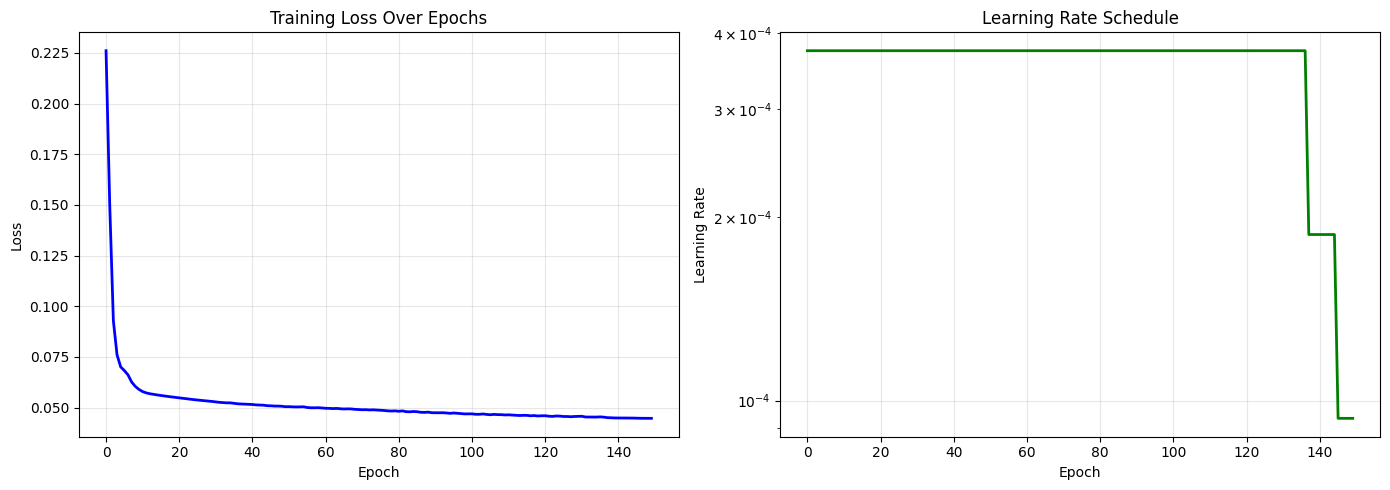


TRAINING SUMMARY
  Initial Loss    : 0.226049
  Final Loss      : 0.044707
  Min Loss        : 0.044707 (Epoch 150)
  Improvement     : 80.2%
  Total Epochs    : 150
  Final LR        : 9.35e-05


In [14]:
# Plot training history
history = AE.model.history.history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss
axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Epochs')
axes[0].grid(True, alpha=0.3)

# Plot 2: Learning Rate (LOG SCALE)
if 'learning_rate' in history:
    lr_data = np.array(history['learning_rate'])
    lr_min, lr_max = lr_data.min(), lr_data.max()
    
    if lr_max > lr_min * 1.1:  # LR changed significantly
        axes[1].semilogy(lr_data, 'g-', linewidth=2)
    else:
        axes[1].plot(lr_data, 'g-', linewidth=2)
        axes[1].set_ylim([lr_min * 0.5, lr_max * 1.5])
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'LR not tracked', ha='center', va='center', fontsize=14)
    axes[1].set_title('Learning Rate (Not Available)')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"  Initial Loss    : {history['loss'][0]:.6f}")
print(f"  Final Loss      : {history['loss'][-1]:.6f}")
print(f"  Min Loss        : {min(history['loss']):.6f} (Epoch {history['loss'].index(min(history['loss'])) + 1})")
print(f"  Improvement     : {((history['loss'][0] - history['loss'][-1]) / history['loss'][0] * 100):.1f}%")
print(f"  Total Epochs    : {len(history['loss'])}")
if 'learning_rate' in history:
    print(f"  Final LR        : {history['learning_rate'][-1]:.2e}")
print(f"{'='*60}")

## Cleanup

In [15]:
# Finish W&B run
if wandb.run is not None:
    wandb.finish()
    print("W&B run finished successfully.")

batch_finder/model_memory_mb,▁
batch_finder/model_params,▁
batch_finder/optimal_batch_size,▁
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
epoch/learning_rate,███████████████████████████████████████▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,█████████████████████████████████▃▃▃▃▃▁▁
batch_finder/input_shape,"(28, 28, 1)"
batch_finder/model_memory_mb,3.06645
batch_finder/model_params,200963
batch_finder/optimal_batch_size,3680


W&B run finished successfully.


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
#
# NOTE: Only run this cell after all work is complete and saved.
#       The kernel restart will clear all variables and outputs.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)